In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

import pickle
def save_pickle(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In this notebook, we will primarily focus on building 4 deep learning models for recommender system. They are **neuralCF**, **DSSM**, **Wide and Deep**, and **DeepFM**. We will also include some preprocessing on numerical and categorical features, including normalization, one-hot encoding, and embedding. 

### Load data, preprocessing, train-val-test split, and load to tf dataset

In [2]:
# Load final data from preprocessing_2_feature_engineering
data = load_pickle('data.pickle')

In [3]:
# Deal with missing values
# Make na as type 'unknown' to make tensorflow happy
data.fillna({'cast_1':'unknown', 
             'cast_2':'unknown', 
             'movie_genre_1': "unknown", 
             "movie_genre_2":"unknown", 
             'user_fav_genre': "unknown",
             'release_year': data.release_year.mean()}, inplace=True)

In [4]:
# Preprocessing numerical columns
numerical_cols = ['age','IMDb_rating', 'release_year', 'user_avg_rating', 'user_std_rating',  'user_rating_count',
                 'movie_avg_rating', 'movie_std_rating', 'movie_rating_count',]
# Apply normalization techniques to all numerical columns
for column in numerical_cols:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())   

In [5]:
# Define features and genre_cols for future uses
features = ['userId', 'age', 'gender', 'occupation', 'zipcode_bucket',                    # User Features
                 'movieId', 'movie_genre_1', 'movie_genre_2', 'IMDb_rating',              # Movie Features
                 'director', 'cast_1', 'cast_2', 'plot embedding', 'release_year',        # Movie Features
                 'rating', 'user_avg_rating', 'user_std_rating', 'user_rating_count',     # Rating Features
                 'movie_avg_rating', 'movie_std_rating', 'movie_rating_count',            # Rating Features
                 'user_fav_genre', 'user_fav_movieId', 'timestamp'                        # Rating Features        
               ]
genre_cols = ['unknown', 'Action', 'Adventure',
       'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']

In [6]:
# Split features and target
# Note data and X are already sorted by timestamp ascending
X = data.drop(["rating",'plot embedding', 'timestamp'] , axis = 1)
y = data['rating'].astype('float32')

In [58]:
# Create place holders for train, val, and test
# Note I want to retain the column types from original dataframe, so I use X[0:0] 
raw_train = X[0:0]
raw_val = X[0:0]
raw_test = X[0:0]

In [59]:
# Create train-val-test split:  Train 80%, val 10%, test 10%
# Note I split it by user group sorted by timestamp to make sure no future information leakage
for name, group in X.groupby('userId'):
    size = len(group)
    train_size, val_size = int(size * 0.8), int(size * 0.1)
    raw_train = pd.concat([raw_train, group[ : train_size]])
    raw_val = pd.concat([raw_val,group[train_size : train_size+val_size]])       
    raw_test = pd.concat([raw_test,group[train_size+val_size:]])

In [62]:
# Feed into tf dataset
# shuffle and batch
train_ds = tf.data.Dataset.from_tensor_slices((dict(raw_train), y.iloc[raw_train.index])).shuffle(len(raw_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((dict(raw_val), y.iloc[raw_val.index])).shuffle(len(raw_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((dict(raw_test), y.iloc[raw_test.index])).shuffle(len(raw_test)).batch(32)

### Define inputs and feature columns

In [63]:
# Define tensorflow inputs
inputs = {
          # User Features
          'age': tf.keras.layers.Input(name='age', shape=(), dtype='int32'),
          'gender': tf.keras.layers.Input(name='gender', shape=(), dtype='int32'),
          'occupation': tf.keras.layers.Input(name='occupation', shape=(), dtype='string'),
          'zipcode_bucket': tf.keras.layers.Input(name='zipcode_bucket', shape=(), dtype='string'),
    
          # Movie Features
          'movie_genre_1': tf.keras.layers.Input(name='movie_genre_1', shape=(), dtype='string'),
          'movie_genre_2': tf.keras.layers.Input(name='movie_genre_2', shape=(), dtype='string'),
          'IMDb_rating': tf.keras.layers.Input(name='IMDb_rating', shape=(), dtype='int32'),
          'director': tf.keras.layers.Input(name='director', shape=(), dtype='string'),
          'cast_1': tf.keras.layers.Input(name='cast_1', shape=(), dtype='string'),
          'cast_2': tf.keras.layers.Input(name='cast_2', shape=(), dtype='string'),
          'release_year': tf.keras.layers.Input(name='release_year', shape=(), dtype='float32'),
    
          # Rating features
          'movieId': tf.keras.layers.Input(name='movieId', shape=(), dtype='int32'),
          'userId': tf.keras.layers.Input(name='userId', shape=(), dtype='int32'),
          'user_fav_genre': tf.keras.layers.Input(name='user_fav_genre', shape=(), dtype='string'),
          'user_fav_movieId': tf.keras.layers.Input(name='user_fav_movieId', shape=(), dtype='int32'),
    
          'user_avg_rating': tf.keras.layers.Input(name='user_avg_rating', shape=(), dtype='float32'),
          'user_std_rating': tf.keras.layers.Input(name='user_std_rating', shape=(), dtype='float32'),
          'user_rating_count': tf.keras.layers.Input(name='user_rating_count', shape=(), dtype='int32'),
    
          'movie_avg_rating': tf.keras.layers.Input(name='movie_avg_rating', shape=(), dtype='float32'),
          'movie_std_rating': tf.keras.layers.Input(name='movie_std_rating', shape=(), dtype='float32'),
          'movie_rating_count': tf.keras.layers.Input(name='movie_rating_count', shape=(), dtype='int32'),
}

In [64]:
# <--movieId-->
# Categorized
movie_col = tf.feature_column.categorical_column_with_identity(key='movieId', num_buckets=1683)         
# Embedding
movie_emb_col = tf.feature_column.embedding_column(movie_col, 10)
# Indicator
movie_ind_col = tf.feature_column.indicator_column(movie_col)

# <--userId-->
# Categorized
user_col = tf.feature_column.categorical_column_with_identity(key='userId', num_buckets=944)
# Embedding
user_emb_col = tf.feature_column.embedding_column(user_col, 10)
# Indicator
user_ind_col = tf.feature_column.indicator_column(user_col)

# <--occupation-->
# Categorized
occupation_col = tf.feature_column.categorical_column_with_vocabulary_list(key="occupation", vocabulary_list=data['occupation'].unique())
# Embedding
occupation_emb_col = tf.feature_column.embedding_column(occupation_col, 4)

# <--gender-->
# Categorized
gender_col = tf.feature_column.categorical_column_with_identity(key = 'gender', num_buckets= 2)
# Indicator
gender_ind_col = tf.feature_column.indicator_column(gender_col)

# <--zipcode_bucket-->
# Categorized
zipcode_bucket_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'zipcode_bucket', vocabulary_list=data['zipcode_bucket'].unique())
# Embedding
zipcode_bucket_emb_col = tf.feature_column.embedding_column(zipcode_bucket_col, 10)

# <--movie_genre-->
# Categorized
movie_genre_1_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'movie_genre_1', vocabulary_list=genre_cols)
movie_genre_2_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'movie_genre_2', vocabulary_list=genre_cols)
# Embedding
movie_genre_1_emd_col = tf.feature_column.embedding_column(movie_genre_1_col, 10)
movie_genre_2_emd_col = tf.feature_column.embedding_column(movie_genre_2_col, 10)
# Indicator
movie_genre_1_ind_col = tf.feature_column.indicator_column(movie_genre_1_col)

# <--director-->
# Categorized
director_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'director', vocabulary_list=data['director'].unique())
# Embedding
director_emb_col = tf.feature_column.embedding_column(director_col, 10)

# <--cast-->
# Create set to store all the actor names
actor_set = set(data['cast_2'].unique()) | set(data['cast_1'].unique())
# Categorized
cast_1_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'cast_1', vocabulary_list=actor_set)
cast_2_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'cast_2', vocabulary_list=actor_set)
# Embedding
cast_1_emb_col = tf.feature_column.embedding_column(cast_1_col, 10)
cast_2_emb_col = tf.feature_column.embedding_column(cast_2_col, 10)



# <--user_fav_genre-->
# Categorized
user_fav_genre_col = tf.feature_column.categorical_column_with_vocabulary_list(key = 'user_fav_genre', vocabulary_list=genre_cols)
# Embedding
user_fav_genre_emb_col = tf.feature_column.embedding_column(user_fav_genre_col, 10)
# Indicator
user_fav_genre_ind_col = tf.feature_column.indicator_column(user_fav_genre_col)

# <--user_fav_movieId-->
# Categorized
user_fav_movieId_col = tf.feature_column.categorical_column_with_identity(key='user_fav_movieId', num_buckets=1683)     
# Embedding
user_fav_movieId_emb_col = tf.feature_column.embedding_column(user_fav_movieId_col, 10)

categorical_columns = [movie_emb_col, user_emb_col, occupation_emb_col, gender_ind_col, zipcode_bucket_emb_col,  movie_genre_1_emd_col, 
                       movie_genre_2_emd_col, director_emb_col, cast_1_emb_col, cast_2_emb_col, user_fav_genre_emb_col,
                       user_fav_movieId_emb_col]

In [65]:
age_col = tf.feature_column.numeric_column('age')

IMDb_rating_col = tf.feature_column.numeric_column('IMDb_rating')
release_year_col = tf.feature_column.numeric_column('release_year')

user_avg_rating_col = tf.feature_column.numeric_column('user_avg_rating')
user_std_rating_col = tf.feature_column.numeric_column('user_std_rating')
user_rating_count_col = tf.feature_column.numeric_column('user_rating_count')

movie_avg_rating_col = tf.feature_column.numeric_column('movie_avg_rating')
movie_std_rating_col = tf.feature_column.numeric_column('movie_std_rating')
movie_rating_count_col = tf.feature_column.numeric_column('movie_rating_count')

numerical_columns = [age_col ,IMDb_rating_col , release_year_col, user_avg_rating_col , user_std_rating_col , user_rating_count_col ,
                     movie_avg_rating_col , movie_std_rating_col , movie_rating_count_col]

### Define Models

#### Utility functions

In [66]:
# Define function to plot training and validation loss (rmse)
def plot(history):
    rmse = history.history['loss']
    val_rmse = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(rmse))

    plt.title('Training and validation rmse')
    plt.plot(epochs, rmse, color='blue', label='Train')
    plt.plot(epochs, val_rmse, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('rmse')
    plt.legend()

In [67]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=8,
    mode='auto',
    restore_best_weights=True)

#### NeuralCF
a neural network approach to solve matrix factorization of co-occurrence matrix

In [68]:
# NeuralCF

# Concatenate userId embedding and movieId embedding at first then pass through MLP or several dense layers 
mlp = tf.keras.layers.concatenate([tf.keras.layers.DenseFeatures([movie_emb_col])(inputs), tf.keras.layers.DenseFeatures([user_emb_col])(inputs)])

# Some hidden dense layers
mlp = tf.keras.layers.Dense(64, activation='relu')(mlp)
mlp = tf.keras.layers.Dense(32, activation='relu')(mlp)

# Output Layer
neuralCF_output_layer = tf.keras.layers.Dense(1)(mlp)

# Define model
neuralCF_model = tf.keras.Model(inputs, neuralCF_output_layer)

In [47]:
neuralCF_model.compile(
    loss=rmse,
    optimizer='adam'
)

neuralCF_history = neuralCF_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=200)

Epoch 1/200
2497/2497 [==============================] - 7s 2ms/step - loss: 1.0841 - val_loss: 0.9438
Epoch 2/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9463 - val_loss: 0.9333
Epoch 3/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9304 - val_loss: 0.9124
Epoch 4/200
2497/2497 [==============================] - 7s 2ms/step - loss: 0.9192 - val_loss: 0.9143
Epoch 5/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9146 - val_loss: 0.9058
Epoch 6/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9077 - val_loss: 0.8896
Epoch 7/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9043 - val_loss: 0.8839
Epoch 8/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.9030 - val_loss: 0.8868
Epoch 9/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.8980 - val_loss: 0.8776
Epoch 10/200
2497/2497 [==============================] - 7s 3ms/step - l

Epoch 80/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7204 - val_loss: 0.6958
Epoch 81/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7217 - val_loss: 0.7004
Epoch 82/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.7216 - val_loss: 0.7024
Epoch 83/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7185 - val_loss: 0.6912
Epoch 84/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7186 - val_loss: 0.6863
Epoch 85/200
2497/2497 [==============================] - 7s 3ms/step - loss: 0.7172 - val_loss: 0.6875
Epoch 86/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7174 - val_loss: 0.6928
Epoch 87/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7146 - val_loss: 0.6966
Epoch 88/200
2497/2497 [==============================] - 8s 3ms/step - loss: 0.7158 - val_loss: 0.6908
Epoch 89/200
2497/2497 [==============================] - 8s 3ms

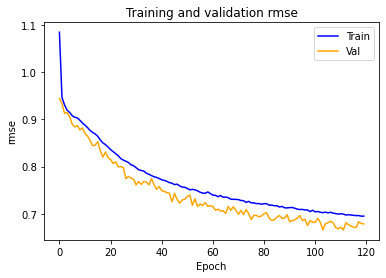

In [49]:
plot(neuralCF_history)

#### DSSM - two tower model 
Improvement upon neuralCF, it adds more information to user and item(movie) inputs and builds MLP tower in user and item(movie) side separately. The last layer is dot embedding of user tower output and item(movie) tower output.

In [64]:
# DSSM two tower model

# movie tower receive inputs regarding information about movie
movie_tower = tf.keras.layers.DenseFeatures([movie_emb_col,
                                            movie_genre_1_emd_col,
                                            movie_genre_2_emd_col,
                                            director_emb_col,
                                            cast_1_emb_col,
                                            cast_2_emb_col] 
                                           + 
                                           [movie_avg_rating_col,
                                            movie_std_rating_col,
                                            movie_rating_count_col,
                                            IMDb_rating_col,
                                            release_year_col])(inputs)

# some dense layers to extract movie features
movie_tower = tf.keras.layers.Dense(64, activation='relu')(movie_tower)
movie_tower = tf.keras.layers.Dense(32, activation='relu')(movie_tower)


# user tower receive inputs regarding information about user
user_tower = tf.keras.layers.DenseFeatures([user_emb_col,
                                            occupation_emb_col,
                                            gender_ind_col,
                                            zipcode_bucket_emb_col,
                                            user_fav_genre_emb_col,
                                            user_fav_movieId_emb_col
                                           ]
                                           +
                                           [user_avg_rating_col,
                                            user_std_rating_col,
                                            user_rating_count_col,
                                            age_col])(inputs)

# some dense layers to extract user features
user_tower = tf.keras.layers.Dense(64, activation='relu')(user_tower)
user_tower = tf.keras.layers.Dense(32, activation='relu')(user_tower)

# a dot product at top for cosine similarity
dssm_output = tf.keras.layers.Dot(axes=1)([movie_tower, user_tower])

# output layer
dssm_output = tf.keras.layers.Dense(1)(output)

# build model
dssm_model = tf.keras.Model(inputs, dssm_output)

In [65]:
dssm_model.compile(
    loss=rmse,
    optimizer='adam'
)

dssm_history = dssm_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=200)

Epoch 1/200
2497/2497 [==============================] - 21s 7ms/step - loss: 0.9240 - val_loss: 0.8165
Epoch 2/200
2497/2497 [==============================] - 19s 7ms/step - loss: 0.8109 - val_loss: 0.7852
Epoch 3/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7929 - val_loss: 0.7648
Epoch 4/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7809 - val_loss: 0.7745
Epoch 5/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7719 - val_loss: 0.7465
Epoch 6/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7634 - val_loss: 0.7318
Epoch 7/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7597 - val_loss: 0.7523
Epoch 8/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7511 - val_loss: 0.7249
Epoch 9/200
2497/2497 [==============================] - 18s 7ms/step - loss: 0.7491 - val_loss: 0.7283
Epoch 10/200
2497/2497 [==============================] - 18s 7m

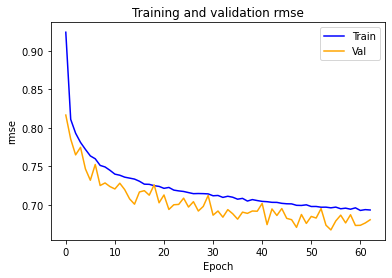

In [73]:
plot(dssm_history)

#### Wide and deep
Include a wide part and a deep part, final layer is these two layers concatenated and pass through a dense layer output.

Wide: Memorization <br>
Inputs to wide layer are sparse features, which are categorical columns in TensorFlow. A crossed column combines these categorical features to construct co-occurrence indicator column. The inputs to wide layer are of design choices since we want to let model remember simple rules as the following: a user who liked movie "Toy Story" likes "Monsters Inc." as well or a user who has liked movie genre "Action" likes movie genre "Adventure" as well.

Deep: Generalization <br>
Inputs to deep layer are dense features, which are numerical columns and embedding columns. 

In [53]:
# wide and deep model

# deep parts receive all the inputs, both categorical, which are converted to embedding, and numerical
wd_deep = tf.keras.layers.DenseFeatures(numerical_columns + categorical_columns)(inputs)

# Two dense layers
wd_deep = tf.keras.layers.Dense(256, activation='relu')(wd_deep)
wd_deep = tf.keras.layers.Dense(128, activation='relu')(wd_deep)

# wide part for cross feature
# the features that go into the wide part are of design choices or from domain knowledge
# it tries to remember when two features always happen together 
crossed_feature = tf.feature_column.indicator_column(tf.feature_column.crossed_column([ movie_col,
                                                                                       user_fav_movieId_col,
                                                                                       movie_genre_1_col, 
                                                                                       user_fav_genre_col], 10000))
wd_wide = tf.keras.layers.DenseFeatures(crossed_feature)(inputs)

# concatenate wide and deep on top
wd_both = tf.keras.layers.concatenate([wd_deep, wd_wide])

# output layer
wd_output_layer = tf.keras.layers.Dense(1)(wd_both)

# build model
wide_and_deep_model = tf.keras.Model(inputs, wd_output_layer)

In [54]:
wide_and_deep_model.compile(
    loss=rmse,
    optimizer='adam'
)
wide_and_deep_history = wide_and_deep_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=200)

Epoch 1/200
2497/2497 [==============================] - 37s 13ms/step - loss: 0.9489 - val_loss: 0.8801
Epoch 2/200
2497/2497 [==============================] - 35s 14ms/step - loss: 0.8768 - val_loss: 0.8513
Epoch 3/200
2497/2497 [==============================] - 37s 15ms/step - loss: 0.8529 - val_loss: 0.8175
Epoch 4/200
2497/2497 [==============================] - 38s 15ms/step - loss: 0.8356 - val_loss: 0.8197
Epoch 5/200
2497/2497 [==============================] - 40s 16ms/step - loss: 0.8098 - val_loss: 0.7628
Epoch 6/200
2497/2497 [==============================] - 42s 17ms/step - loss: 0.7870 - val_loss: 0.7509
Epoch 7/200
2497/2497 [==============================] - 39s 16ms/step - loss: 0.7676 - val_loss: 0.7182
Epoch 8/200
2497/2497 [==============================] - 41s 16ms/step - loss: 0.7456 - val_loss: 0.7144
Epoch 9/200
2497/2497 [==============================] - 41s 16ms/step - loss: 0.7256 - val_loss: 0.7091
Epoch 10/200
2497/2497 [==============================]

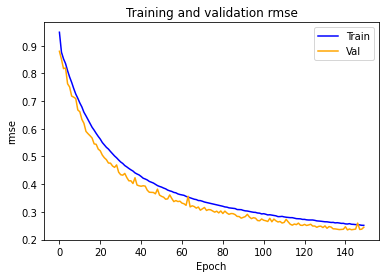

In [74]:
plot(wide_and_deep_history)

#### DeepFM
Uses factorization machine to replace the wide layer in wide and deep model, and the deep part is exactly the same as wide and deep model. <br>
Here we uses an order 2 factorization machine (FM), and the same as the wide part before, inputs to the FM are of design choices. 

In [69]:
# DeepFM model

# factorized machine order 1 interection / linear regression 
fm_first_order_cols = [movie_ind_col, user_ind_col, movie_genre_1_ind_col,user_fav_genre_ind_col]
fm_first_order_layer = tf.keras.layers.DenseFeatures(fm_first_order_cols)(inputs)

# factorized machine order 2 interection, embedding dot product between features
movie_emb_layer = tf.keras.layers.DenseFeatures([movie_emb_col])(inputs)
user_emb_layer = tf.keras.layers.DenseFeatures([user_emb_col])(inputs)
movie_genre_emb_layer = tf.keras.layers.DenseFeatures([movie_genre_1_emd_col])(inputs)
user_genre_emb_layer = tf.keras.layers.DenseFeatures([user_fav_genre_emb_col])(inputs)

# embedding dot product between features
product_layer_movie_user = tf.keras.layers.Dot(axes=1)([movie_emb_layer, user_emb_layer])
product_layer_movie_genre_user_genre = tf.keras.layers.Dot(axes=1)([movie_genre_emb_layer, user_genre_emb_layer])
product_layer_movie_genre_user = tf.keras.layers.Dot(axes=1)([movie_genre_emb_layer, user_emb_layer])
product_layer_user_genre_movie = tf.keras.layers.Dot(axes=1)([user_genre_emb_layer, movie_emb_layer])

# deep part of this model is exactly the same as that in wide and deep model
deepfm_deep = tf.keras.layers.DenseFeatures(numerical_columns + categorical_columns)(inputs)
deepfm_deep = tf.keras.layers.Dense(256, activation='relu')(deepfm_deep)
deepfm_deep = tf.keras.layers.Dense(128, activation='relu')(deepfm_deep)

# concatenate everything together at the end
deepfm_concat_layer = tf.keras.layers.concatenate([fm_first_order_layer, 
                                            product_layer_movie_user, 
                                            product_layer_movie_genre_user_genre,
                                            product_layer_movie_genre_user,
                                            product_layer_user_genre_movie,
                                            deepfm_deep
                                           ], axis=1)
# output layer
deepfm_output_layer = tf.keras.layers.Dense(1)(deepfm_concat_layer)

# build model
deepfm_model = tf.keras.Model(inputs, deepfm_output_layer)

In [71]:
deepfm_model.compile(
    loss=rmse,
    optimizer='adam'
)
deepfm_history = deepfm_model.fit(train_ds,
                validation_data = val_ds, 
                callbacks=[early_stopping],
                epochs=200)

Epoch 1/200
2497/2497 [==============================] - 50s 18ms/step - loss: 0.9459 - val_loss: 0.8814
Epoch 2/200
2497/2497 [==============================] - 44s 18ms/step - loss: 0.8810 - val_loss: 0.8612
Epoch 3/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.8575 - val_loss: 0.8235
Epoch 4/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.8321 - val_loss: 0.8112
Epoch 5/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.8012 - val_loss: 0.7497
Epoch 6/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.7715 - val_loss: 0.7578
Epoch 7/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.7462 - val_loss: 0.7045
Epoch 8/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.7192 - val_loss: 0.6702
Epoch 9/200
2497/2497 [==============================] - 45s 18ms/step - loss: 0.6953 - val_loss: 0.6790
Epoch 10/200
2497/2497 [==============================]

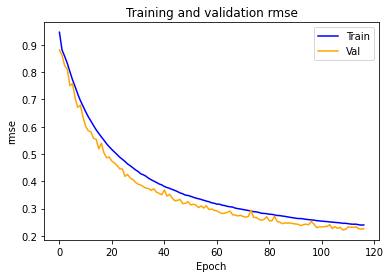

In [75]:
plot(deepfm_history)

### Analyze result and save model

In [72]:
result_df_neuralCF = pd.DataFrame.from_dict(neuralCF_model.evaluate(test_ds, return_dict = True), orient='index',columns = ["neuralCF"]).transpose()
result_df_dssm = pd.DataFrame.from_dict(dssm_model.evaluate(test_ds, return_dict = True), orient='index',columns = ["dssm"]).transpose()
result_df_wide_and_deep = pd.DataFrame.from_dict(wide_and_deep_model.evaluate(test_ds, return_dict = True), orient='index',columns = ["wide_and_deep"]).transpose()
result_df_deepfm = pd.DataFrame.from_dict(deepfm_model.evaluate(test_ds, return_dict = True), orient='index',columns = ["deepfm"]).transpose()

result_df = pd.concat([result_df_neuralCF,result_df_dssm,result_df_wide_and_deep,result_df_deepfm])
result_df.columns = ['test loss (rmse)']
result_df

313/313 [==============================] - 3s 6ms/step - loss: 0.2247


,test loss (rmse)
neuralCF,0.676449
dssm,0.689409
wide_and_deep,0.244740
deepfm,0.224691


The result is quite interesting but fall under expectations. 

The neuralCF approach performs slightly better dssm, yet neuralCF uses only movieId embedding and userId embedding whereas dssm uses much more richer information on users and movies. The reasons behind is that feature interactions happen differently in neuralCF and dssm. neuralCF use multiple dense layers to capture interaction between user and movie, but in dssm, feature interactions happen separately in user tower and movie tower, and there is no final interaction at the top. However, despite the performance issue, dssm is very easy and fast to deploy in production, which is extremely engineering friendly. The outputs from user tower and movie tower can be stored in memory (probably distributed memory like Redis) beforehand and real time inference speed is very fast. The dssm model is widely used in candidate retrieval process.

Wide and deep model and deepfm model beat the above two with overwhelmingly better performance. Wide and deep not only include a deep neural network to capture interaction between user and movie features, it also have a wide layer to remember things when they often co-occur with each other. In the original Google usage of wide and deep model, Google is recommending new apps in their Google Play Store, and the input features to the wide layer are impression_app_id and user_installed_app_id. To mimic such effort, I choose user_fav_movieId, current movieId, user_fav_genre, and current genre. The results turn out to be fantastic with 0.245 rmse on testing set.

The deepfm does outperform wide and deep model by 0.02 in rmse, which proves the effectiveness of replacing a wide part, which is basically a co-occurrence indicator columns on a linear regression, with an order 2 Factorization Machine.

In [89]:
# Save models to disk
neuralCF_model.save('neuralCF', include_optimizer=False)
dssm_model.save('dssm', include_optimizer=False)
wide_and_deep_model.save('wide_and_deep', include_optimizer=False)
deepfm_model.save('deepfm',include_optimizer=False)

INFO:tensorflow:Assets written to: neuralCF\assets


INFO:tensorflow:Assets written to: neuralCF\assets


INFO:tensorflow:Assets written to: dssm\assets


INFO:tensorflow:Assets written to: dssm\assets


INFO:tensorflow:Assets written to: wide_and_deep\assets


INFO:tensorflow:Assets written to: wide_and_deep\assets


INFO:tensorflow:Assets written to: deepfm\assets


INFO:tensorflow:Assets written to: deepfm\assets
